# Weight transfer experiments

In this notebook, we conduct weight transfer experiments on MNIST.

## Change working directory to project root

In [44]:
import os
ROOT_DIRECTORIES = {'dogwood', 'tests'}
if set(os.listdir('.')).intersection(ROOT_DIRECTORIES) != ROOT_DIRECTORIES:
    os.chdir('../..')

## Experiments

In [45]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from dogwood.weight_transfer import are_symmetric_dense_neurons, \
    expand_dense_layer, expand_dense_layers, clone_layer

MAX_PIXEL_VALUE = 255
MNIST_IMAGE_SHAPE = (28, 28)

In [46]:
# TODO should we make MNIST a versioned dataset?
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = tf.cast(X_train, tf.float32) / MAX_PIXEL_VALUE
X_test = tf.cast(X_test, tf.float32) / MAX_PIXEL_VALUE

In [47]:
def get_small_model(num_hidden=1):
    model = Sequential([
        Flatten(input_shape=MNIST_IMAGE_SHAPE, name='flatten'),
        Dense(num_hidden, activation='relu', name='dense_1'),
        Dense(10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    return model

**One hidden layer weight expansion experiment on MNIST**

In this experiment, we compare the training progress of models trained from scratch against those with partially pretrained weights. We also compare their performance on the test data after training.

In [50]:
batch_size = 32
epochs = 20
from_scratch_histories = {}
from_scratch_eval = {}
expanded_histories = {}
expanded_eval = {}
expanded_model = None
for num_hidden in range(1, 6):
    from_scratch_model = get_small_model(num_hidden)
    history = from_scratch_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
    from_scratch_histories[num_hidden] = history
    acc = from_scratch_model.evaluate(X_test, y_test)[1]
    from_scratch_eval[num_hidden] = acc
    # The first iteration, the expanded model is created from scratch.
    # Every other iteration, expand.
    if not expanded_model:
        expanded_model = get_small_model(num_hidden)
    else:
        expanded_model = expand_dense_layer(expanded_model, 'dense_1', 1)
        expanded_model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy'])
    history = expanded_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
    expanded_histories[num_hidden] = history
    acc = expanded_model.evaluate(X_test, y_test)[1]
    expanded_eval[num_hidden] = acc

Epoch 1/20
1875/1875 [==============================] - 1s 545us/step - loss: 1.9966 - sparse_categorical_accuracy: 0.2254
Epoch 2/20
1875/1875 [==============================] - 1s 544us/step - loss: 1.8386 - sparse_categorical_accuracy: 0.2740
Epoch 3/20
1875/1875 [==============================] - 1s 557us/step - loss: 1.7670 - sparse_categorical_accuracy: 0.2998
Epoch 4/20
1875/1875 [==============================] - 1s 587us/step - loss: 1.7291 - sparse_categorical_accuracy: 0.3197
Epoch 5/20
1875/1875 [==============================] - 1s 553us/step - loss: 1.7041 - sparse_categorical_accuracy: 0.3345
Epoch 6/20
1875/1875 [==============================] - 1s 561us/step - loss: 1.6853 - sparse_categorical_accuracy: 0.3426
Epoch 7/20
1875/1875 [==============================] - 1s 560us/step - loss: 1.6714 - sparse_categorical_accuracy: 0.3391
Epoch 8/20
1875/1875 [==============================] - 1s 563us/step - loss: 1.6609 - sparse_categorical_accuracy: 0.3417
Epoch 9/20
1875/

1875/1875 [==============================] - 1s 672us/step - loss: 1.0429 - sparse_categorical_accuracy: 0.6431
Epoch 5/20
1875/1875 [==============================] - 1s 666us/step - loss: 1.0316 - sparse_categorical_accuracy: 0.6469
Epoch 6/20
1875/1875 [==============================] - 1s 676us/step - loss: 1.0224 - sparse_categorical_accuracy: 0.6513
Epoch 7/20
1875/1875 [==============================] - 1s 667us/step - loss: 1.0149 - sparse_categorical_accuracy: 0.6525
Epoch 8/20
1875/1875 [==============================] - 1s 665us/step - loss: 1.0086 - sparse_categorical_accuracy: 0.6529
Epoch 9/20
1875/1875 [==============================] - 1s 655us/step - loss: 1.0033 - sparse_categorical_accuracy: 0.6664
Epoch 10/20
1875/1875 [==============================] - 1s 643us/step - loss: 0.9985 - sparse_categorical_accuracy: 0.6733
Epoch 11/20
1875/1875 [==============================] - 1s 656us/step - loss: 0.9938 - sparse_categorical_accuracy: 0.6727
Epoch 12/20
1875/1875 [==

1875/1875 [==============================] - 1s 682us/step - loss: 0.5201 - sparse_categorical_accuracy: 0.8502
Epoch 8/20
1875/1875 [==============================] - 1s 678us/step - loss: 0.5109 - sparse_categorical_accuracy: 0.8529
Epoch 9/20
1875/1875 [==============================] - 1s 652us/step - loss: 0.5027 - sparse_categorical_accuracy: 0.8554
Epoch 10/20
1875/1875 [==============================] - 1s 644us/step - loss: 0.4967 - sparse_categorical_accuracy: 0.8570
Epoch 11/20
1875/1875 [==============================] - 1s 648us/step - loss: 0.4916 - sparse_categorical_accuracy: 0.8589
Epoch 12/20
1875/1875 [==============================] - 1s 680us/step - loss: 0.4859 - sparse_categorical_accuracy: 0.8600
Epoch 13/20
1875/1875 [==============================] - 1s 656us/step - loss: 0.4808 - sparse_categorical_accuracy: 0.8607
Epoch 14/20
1875/1875 [==============================] - 1s 649us/step - loss: 0.4763 - sparse_categorical_accuracy: 0.8618
Epoch 15/20
1875/1875 

1875/1875 [==============================] - 1s 645us/step - loss: 0.3335 - sparse_categorical_accuracy: 0.9072
Epoch 11/20
1875/1875 [==============================] - 1s 644us/step - loss: 0.3322 - sparse_categorical_accuracy: 0.9066
Epoch 12/20
1875/1875 [==============================] - 1s 633us/step - loss: 0.3320 - sparse_categorical_accuracy: 0.9074
Epoch 13/20
1875/1875 [==============================] - 1s 639us/step - loss: 0.3312 - sparse_categorical_accuracy: 0.9064
Epoch 14/20
1875/1875 [==============================] - 1s 637us/step - loss: 0.3309 - sparse_categorical_accuracy: 0.9076
Epoch 15/20
1875/1875 [==============================] - 1s 635us/step - loss: 0.3301 - sparse_categorical_accuracy: 0.9077
Epoch 16/20
1875/1875 [==============================] - 1s 754us/step - loss: 0.3298 - sparse_categorical_accuracy: 0.9080
Epoch 17/20
1875/1875 [==============================] - 2s 832us/step - loss: 0.3292 - sparse_categorical_accuracy: 0.9078
Epoch 18/20
1875/187

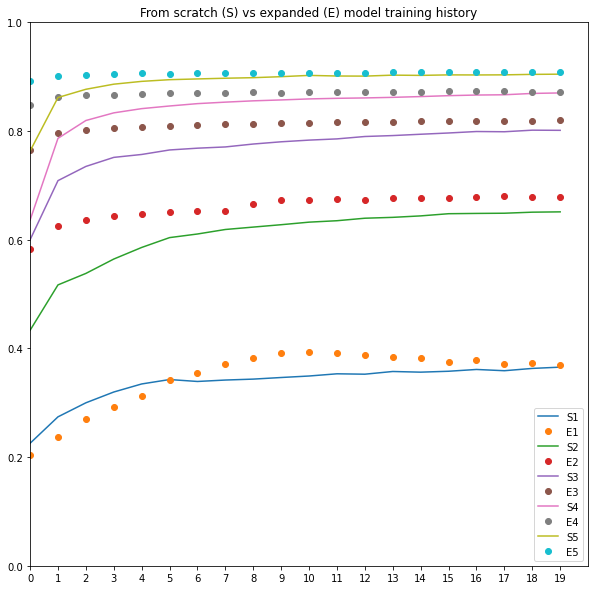

In [51]:
fig, ax = plt.subplots(figsize=(10, 10))
for num_hidden in sorted(from_scratch_histories.keys()):    
    plt.plot(from_scratch_histories[num_hidden].history['sparse_categorical_accuracy'], '-', label=f'S{num_hidden}')
    plt.plot(expanded_histories[num_hidden].history['sparse_categorical_accuracy'], 'o', label=f'E{num_hidden}')
plt.legend()
plt.title('From scratch (S) vs expanded (E) model training history')
plt.xlim([0, epochs])
plt.ylim([0, 1])
plt.xticks(list(range(epochs)))
plt.show()

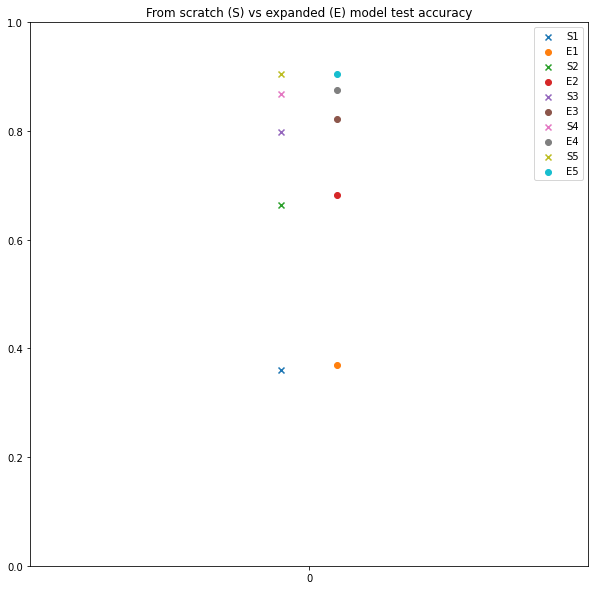

In [60]:
fig, ax = plt.subplots(figsize=(10, 10))
for num_hidden in sorted(from_scratch_eval.keys()):    
    plt.scatter(-0.1, from_scratch_eval[num_hidden], marker='x', label=f'S{num_hidden}')
    plt.scatter(0.1, expanded_eval[num_hidden], marker='o', label=f'E{num_hidden}')
plt.legend()
plt.title('From scratch (S) vs expanded (E) model test accuracy')
plt.xlim([-1, 1])
plt.ylim([0, 1])
plt.xticks([0])
plt.show()